<div style="text-align: center; line-height: 0; padding-top: 2px;">
  <img src="https://www.quantiaconsulting.com/logos/quantia_logo_orizz.png" alt="Quantia Consulting" style="width: 600px; height: 250px">
</div>

# Final Challenge B - Solution
---

## Using the KDDCup dataset, find the best SML model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

The KDDCup intrusion detection data stream records intrusions simulated in a military network environment. The task is to classify network traffic into **normal** (80.31% of the cases) or some kind of **intrusion** (19.69% of the cases) described by *41 features*, of which *34 numeric* and *7 nominal*. The problem of temporal dependence is particularly evident here. Inspecting the raw stream confirms that there are time periods of intrusions rather than single instances of intrusions.
The *7 nominal* attributes are:
- protocol_type
- service
- flag
- land
- logged_in
- is_host_login
- is_guest_login

**Class:** `class` | 0: normal, 1: intrusion
 
**Samples:** 494021


In [2]:
df = pd.read_csv("../datasets/KDDCup.csv")
features = df.columns[:-1]
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

## Plot data distribution
---
Encode the protocol_type, service and flag attributes and apply the **PCA**

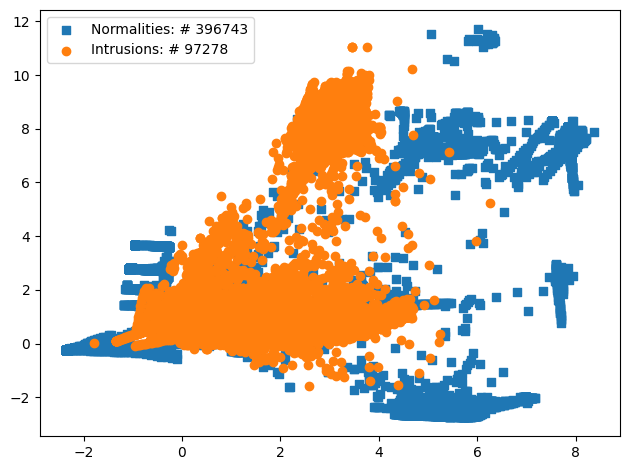

In [3]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

encoder = OrdinalEncoder()
encDf = df.copy()
encDf[["protocol_type","service","flag"]] = encoder.fit_transform(encDf[["protocol_type","service","flag"]])


features = encDf.drop(["class"],axis=1)
label = encDf["class"]

scaled_features = StandardScaler().fit_transform(features)
num_components = 2
pca = PCA(n_components=num_components)
pca_data = pca.fit_transform(scaled_features)
pca_data.shape

pc_df = pd.DataFrame(data = pca_data,columns = ["pc1", "pc2"])
pc_df["class"] = label

normalities = pc_df[pc_df["class"] == 0]
intrusions = pc_df[pc_df["class"] == 1]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x=normalities["pc1"], y=normalities["pc2"], marker="s", label='Normalities: # ' + str(normalities.shape[0]))
ax1.scatter(x=intrusions["pc1"], y=intrusions["pc2"], marker="o", label='Intrusions: # ' + str(intrusions.shape[0]))
plt.legend(loc='upper left');
fig.tight_layout()
plt.show()

## Find the best SML model!
---
### Hint
Since the stream is imbalances, the Accuracy is not a reliable metric. Try using [BalancedAccuracy](https://riverml.xyz/latest/api/metrics/BalancedAccuracy/) and [GeometricMean](https://riverml.xyz/latest/api/metrics/GeometricMean/) instead. To combine them, use [Metrics](https://riverml.xyz/latest/api/metrics/Metrics/)

In [4]:
from river.stream import iter_pandas
from river.evaluate import progressive_val_score
from river.metrics import Rolling,Metrics,Accuracy,BalancedAccuracy,GeometricMean,CohenKappa
from river import compose

## Naïve Bayes

In [6]:
from river.naive_bayes import GaussianNB

model = (
    compose.Discard('protocol_type','service', 'flag') |
    GaussianNB()
)
features = df.columns[:-1]
metrics = Rolling(metric=Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=10000)
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=10000)

[10,000] Accuracy: 77.87%, BalancedAccuracy: 50.00%, GeometricMean: 0.00%, CohenKappa: 0.00%	(rolling 10000)
[20,000] Accuracy: 83.92%, BalancedAccuracy: 50.00%, GeometricMean: 0.00%, CohenKappa: 0.00%	(rolling 10000)
[30,000] Accuracy: 98.42%, BalancedAccuracy: 51.84%, GeometricMean: 19.18%, CohenKappa: 6.93%	(rolling 10000)
[40,000] Accuracy: 97.37%, BalancedAccuracy: 67.78%, GeometricMean: 60.09%, CohenKappa: 42.39%	(rolling 10000)
[50,000] Accuracy: 77.81%, BalancedAccuracy: 50.26%, GeometricMean: 7.34%, CohenKappa: 0.81%	(rolling 10000)
[60,000] Accuracy: 86.43%, BalancedAccuracy: 50.81%, GeometricMean: 14.96%, CohenKappa: 2.68%	(rolling 10000)
[70,000] Accuracy: 100.00%, BalancedAccuracy: 100.00%, GeometricMean: 100.00%, CohenKappa: 0.00%	(rolling 10000)
[80,000] Accuracy: 75.52%, BalancedAccuracy: 78.84%, GeometricMean: 75.96%, CohenKappa: 53.46%	(rolling 10000)
[90,000] Accuracy: 90.09%, BalancedAccuracy: 81.62%, GeometricMean: 81.10%, CohenKappa: 33.57%	(rolling 10000)
[100,00

Accuracy: 90.33%, BalancedAccuracy: 91.22%, GeometricMean: 90.82%, CohenKappa: 80.83%	(rolling 10000)

## Hoeffding Adaptive Tree

In [7]:
from river.tree import HoeffdingAdaptiveTreeClassifier

model = HoeffdingAdaptiveTreeClassifier(nominal_attributes=['protocol_type','service', 'flag'], seed=42)
metrics = Rolling(metric=Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=10000)
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream, 
                      model=model, 
                      metric=metrics, 
                      print_every=10000)

[10,000] Accuracy: 99.69%, BalancedAccuracy: 99.53%, GeometricMean: 99.53%, CohenKappa: 99.10%	(rolling 10000)
[20,000] Accuracy: 99.81%, BalancedAccuracy: 99.81%, GeometricMean: 99.81%, CohenKappa: 99.30%	(rolling 10000)
[30,000] Accuracy: 99.79%, BalancedAccuracy: 95.07%, GeometricMean: 94.94%, CohenKappa: 93.23%	(rolling 10000)
[40,000] Accuracy: 98.95%, BalancedAccuracy: 81.42%, GeometricMean: 79.28%, CohenKappa: 76.51%	(rolling 10000)
[50,000] Accuracy: 98.33%, BalancedAccuracy: 98.38%, GeometricMean: 98.38%, CohenKappa: 95.26%	(rolling 10000)
[60,000] Accuracy: 99.02%, BalancedAccuracy: 97.81%, GeometricMean: 97.80%, CohenKappa: 95.75%	(rolling 10000)
[70,000] Accuracy: 99.81%, BalancedAccuracy: 49.91%, GeometricMean: 0.00%, CohenKappa: 0.00%	(rolling 10000)
[80,000] Accuracy: 99.18%, BalancedAccuracy: 99.12%, GeometricMean: 99.12%, CohenKappa: 98.32%	(rolling 10000)
[90,000] Accuracy: 98.61%, BalancedAccuracy: 92.09%, GeometricMean: 91.82%, CohenKappa: 82.75%	(rolling 10000)
[10

Accuracy: 97.63%, BalancedAccuracy: 97.44%, GeometricMean: 97.42%, CohenKappa: 95.19%	(rolling 10000)

## Adaptive Random Forest

In [8]:
from river.ensemble import AdaptiveRandomForestClassifier

model = AdaptiveRandomForestClassifier(n_models=5,nominal_attributes=['protocol_type','service', 'flag'])
metrics = Rolling(metric=Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=10000)
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=10000)

[10,000] Accuracy: 99.87%, BalancedAccuracy: 99.71%, GeometricMean: 99.71%, CohenKappa: 99.62%	(rolling 10000)
[20,000] Accuracy: 99.75%, BalancedAccuracy: 99.30%, GeometricMean: 99.30%, CohenKappa: 99.07%	(rolling 10000)
[30,000] Accuracy: 99.71%, BalancedAccuracy: 91.71%, GeometricMean: 91.33%, CohenKappa: 90.22%	(rolling 10000)
[40,000] Accuracy: 99.73%, BalancedAccuracy: 95.35%, GeometricMean: 95.24%, CohenKappa: 94.81%	(rolling 10000)
[50,000] Accuracy: 99.59%, BalancedAccuracy: 99.46%, GeometricMean: 99.46%, CohenKappa: 98.82%	(rolling 10000)
[60,000] Accuracy: 99.18%, BalancedAccuracy: 98.16%, GeometricMean: 98.15%, CohenKappa: 96.44%	(rolling 10000)
[70,000] Accuracy: 100.00%, BalancedAccuracy: 100.00%, GeometricMean: 100.00%, CohenKappa: 0.00%	(rolling 10000)
[80,000] Accuracy: 99.35%, BalancedAccuracy: 99.28%, GeometricMean: 99.28%, CohenKappa: 98.67%	(rolling 10000)
[90,000] Accuracy: 99.47%, BalancedAccuracy: 94.97%, GeometricMean: 94.85%, CohenKappa: 93.07%	(rolling 10000)

Accuracy: 99.41%, BalancedAccuracy: 99.36%, GeometricMean: 99.36%, CohenKappa: 98.81%	(rolling 10000)

## ADWIN Online Bagging

In [9]:
from river.ensemble import ADWINBaggingClassifier
from river.tree import HoeffdingTreeClassifier

model = ADWINBaggingClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['protocol_type','service', 'flag']),
                          n_models=5,
                          seed=42)
metrics = Rolling(metric=Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=10000)
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=10000)


[10,000] Accuracy: 99.78%, BalancedAccuracy: 99.68%, GeometricMean: 99.68%, CohenKappa: 99.36%	(rolling 10000)
[20,000] Accuracy: 99.84%, BalancedAccuracy: 99.85%, GeometricMean: 99.85%, CohenKappa: 99.41%	(rolling 10000)
[30,000] Accuracy: 99.70%, BalancedAccuracy: 93.21%, GeometricMean: 92.97%, CohenKappa: 90.23%	(rolling 10000)
[40,000] Accuracy: 99.73%, BalancedAccuracy: 95.18%, GeometricMean: 95.06%, CohenKappa: 94.80%	(rolling 10000)
[50,000] Accuracy: 98.82%, BalancedAccuracy: 99.16%, GeometricMean: 99.16%, CohenKappa: 96.65%	(rolling 10000)
[60,000] Accuracy: 97.37%, BalancedAccuracy: 94.77%, GeometricMean: 94.70%, CohenKappa: 88.71%	(rolling 10000)
[70,000] Accuracy: 100.00%, BalancedAccuracy: 100.00%, GeometricMean: 100.00%, CohenKappa: 0.00%	(rolling 10000)
[80,000] Accuracy: 99.22%, BalancedAccuracy: 99.14%, GeometricMean: 99.14%, CohenKappa: 98.40%	(rolling 10000)
[90,000] Accuracy: 98.63%, BalancedAccuracy: 90.60%, GeometricMean: 90.17%, CohenKappa: 82.43%	(rolling 10000)

Accuracy: 99.58%, BalancedAccuracy: 99.58%, GeometricMean: 99.58%, CohenKappa: 99.15%	(rolling 10000)

## Leveraging Bagging

In [10]:
from river.ensemble import LeveragingBaggingClassifier
from river.tree import HoeffdingTreeClassifier

model = LeveragingBaggingClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['protocol_type','service', 'flag']),
                          n_models=5,
                          seed=42)
metrics = Rolling(metric=Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=10000)
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=10000)

[10,000] Accuracy: 99.84%, BalancedAccuracy: 99.69%, GeometricMean: 99.69%, CohenKappa: 99.53%	(rolling 10000)
[20,000] Accuracy: 99.94%, BalancedAccuracy: 99.84%, GeometricMean: 99.84%, CohenKappa: 99.78%	(rolling 10000)
[30,000] Accuracy: 99.82%, BalancedAccuracy: 95.69%, GeometricMean: 95.59%, CohenKappa: 94.21%	(rolling 10000)
[40,000] Accuracy: 99.65%, BalancedAccuracy: 93.92%, GeometricMean: 93.73%, CohenKappa: 93.18%	(rolling 10000)
[50,000] Accuracy: 99.21%, BalancedAccuracy: 98.82%, GeometricMean: 98.82%, CohenKappa: 97.72%	(rolling 10000)
[60,000] Accuracy: 99.49%, BalancedAccuracy: 99.32%, GeometricMean: 99.32%, CohenKappa: 97.81%	(rolling 10000)
[70,000] Accuracy: 100.00%, BalancedAccuracy: 100.00%, GeometricMean: 100.00%, CohenKappa: 0.00%	(rolling 10000)
[80,000] Accuracy: 99.36%, BalancedAccuracy: 99.31%, GeometricMean: 99.30%, CohenKappa: 98.69%	(rolling 10000)
[90,000] Accuracy: 99.57%, BalancedAccuracy: 95.72%, GeometricMean: 95.63%, CohenKappa: 94.39%	(rolling 10000)

Accuracy: 99.45%, BalancedAccuracy: 99.42%, GeometricMean: 99.42%, CohenKappa: 98.89%	(rolling 10000)

## Streaming Random Patches

In [11]:
from river.ensemble import SRPClassifier
from river.tree import HoeffdingTreeClassifier
from river.drift import ADWIN

model = SRPClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['protocol_type','service', 'flag']),
                      n_models=5,
                      drift_detector=ADWIN(delta=0.001),
                      warning_detector=ADWIN(delta=0.01),
                      seed=42)
metrics = Rolling(metric=Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=10000)
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream, 
                      model=model, 
                      metric=metrics, 
                      print_every=10000)

[10,000] Accuracy: 99.81%, BalancedAccuracy: 99.64%, GeometricMean: 99.63%, CohenKappa: 99.45%	(rolling 10000)
[20,000] Accuracy: 99.97%, BalancedAccuracy: 99.93%, GeometricMean: 99.93%, CohenKappa: 99.89%	(rolling 10000)
[30,000] Accuracy: 99.83%, BalancedAccuracy: 95.69%, GeometricMean: 95.59%, CohenKappa: 94.52%	(rolling 10000)
[40,000] Accuracy: 99.57%, BalancedAccuracy: 92.49%, GeometricMean: 92.19%, CohenKappa: 91.50%	(rolling 10000)
[50,000] Accuracy: 99.55%, BalancedAccuracy: 99.65%, GeometricMean: 99.65%, CohenKappa: 98.71%	(rolling 10000)
[60,000] Accuracy: 99.24%, BalancedAccuracy: 98.89%, GeometricMean: 98.89%, CohenKappa: 96.74%	(rolling 10000)
[70,000] Accuracy: 100.00%, BalancedAccuracy: 100.00%, GeometricMean: 100.00%, CohenKappa: 0.00%	(rolling 10000)
[80,000] Accuracy: 99.69%, BalancedAccuracy: 99.65%, GeometricMean: 99.65%, CohenKappa: 99.36%	(rolling 10000)
[90,000] Accuracy: 99.06%, BalancedAccuracy: 90.47%, GeometricMean: 89.99%, CohenKappa: 87.21%	(rolling 10000)

Accuracy: 99.69%, BalancedAccuracy: 99.69%, GeometricMean: 99.69%, CohenKappa: 99.37%	(rolling 10000)